In [1]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH = './Datasets/Cards/'

Directorio actual: /tf/CNN-Cards


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import json
from pathlib import Path

# Global variables
SIZE = 224
CLASSES = 53

path_models = 'Models'

print(f'TensorFlow version: {tf.__version__}')

2025-12-09 23:35:17.132523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-09 23:35:17.132587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-09 23:35:17.133782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0


## Cargar nombres de clases

In [3]:
# Obtener nombres de clases del directorio de entrenamiento
train_path = Path(DATA_PATH) / 'train'
CLASS_NAMES = sorted([d.name for d in train_path.iterdir() if d.is_dir()])

print(f'Numero de clases: {len(CLASS_NAMES)}')
print(f'Clases: {CLASS_NAMES[:5]}... {CLASS_NAMES[-5:]}')

Numero de clases: 53
Clases: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs']... ['three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


## Clase CardClassifier

In [4]:
class CardClassifier:
    """Clasificador de cartas con soporte para modelo individual o ensemble"""
    
    def __init__(self, model_path=None, ensemble_config_path=None, class_names=None):
        """
        Inicializar clasificador.
        
        Args:
            model_path: Ruta a un modelo .h5 individual
            ensemble_config_path: Ruta a ensemble_config.json para usar ensemble
            class_names: Lista de nombres de clases
        """
        self.class_names = class_names or CLASS_NAMES
        self.models = []
        self.weights = []
        self.is_ensemble = False
        
        # Importar vit_keras para custom objects (necesario para modelos ViT)
        try:
            from vit_keras import vit, layers as vit_layers
            
            # Obtener TODOS los custom objects del modulo vit_keras dinamicamente
            self.custom_objects = {}
            for name_obj in dir(vit_layers):
                obj = getattr(vit_layers, name_obj)
                if isinstance(obj, type):
                    self.custom_objects[name_obj] = obj
            
            for name_obj in dir(vit):
                obj = getattr(vit, name_obj)
                if isinstance(obj, type):
                    self.custom_objects[name_obj] = obj
            
            print(f"Custom objects ViT registrados: {len(self.custom_objects)}")
        except ImportError:
            print("vit_keras no disponible, solo se cargaran modelos MobileNet y Custom")
            self.custom_objects = {}
        
        if ensemble_config_path and os.path.exists(ensemble_config_path):
            self._load_ensemble(ensemble_config_path)
        elif model_path:
            self._load_single_model(model_path)
        else:
            # Cargar el mejor modelo disponible por defecto
            self._load_best_available()
    
    def _load_single_model(self, model_path):
        """Cargar un modelo individual"""
        print(f'Cargando modelo: {model_path}')
        
        # Detectar si es modelo ViT por el nombre
        is_vit = 'ViT' in os.path.basename(model_path)
        
        if is_vit and self.custom_objects:
            model = tf.keras.models.load_model(
                model_path,
                custom_objects=self.custom_objects,
                compile=False
            )
            model.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
        else:
            model = tf.keras.models.load_model(model_path)
        
        self.models = [model]
        self.weights = [1.0]
        self.is_ensemble = False
    
    def _load_ensemble(self, config_path):
        """Cargar ensemble desde configuracion"""
        print(f'Cargando ensemble desde: {config_path}')
        
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        model_dir = os.path.dirname(config_path)
        
        for model_file in config['model_files']:
            model_path = os.path.join(model_dir, model_file)
            if os.path.exists(model_path):
                print(f'  Cargando: {model_file}')
                
                # Detectar si es modelo ViT por el nombre
                is_vit = 'ViT' in model_file
                
                try:
                    if is_vit and self.custom_objects:
                        model = tf.keras.models.load_model(
                            model_path,
                            custom_objects=self.custom_objects,
                            compile=False
                        )
                        model.compile(
                            optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy']
                        )
                    else:
                        model = tf.keras.models.load_model(model_path)
                    
                    self.models.append(model)
                except Exception as e:
                    print(f'  ✗ Error cargando {model_file}: {e}')
        
        # Obtener pesos
        weights_dict = config.get('weights', {})
        self.weights = list(weights_dict.values()) if weights_dict else [1.0] * len(self.models)
        
        # Normalizar pesos
        total = sum(self.weights)
        self.weights = [w / total for w in self.weights]
        
        self.is_ensemble = len(self.models) > 1
        print(f'Ensemble cargado: {len(self.models)} modelos')
    
    def _load_best_available(self):
        """Cargar el mejor modelo disponible"""
        candidates = ['ViT_B16_3.h5', 'ViT_B16_2.h5', 'MobileNet_3.h5', 'MobileNet_2.h5']
        
        for candidate in candidates:
            model_path = os.path.join(path_models, candidate)
            if os.path.exists(model_path):
                self._load_single_model(model_path)
                return
        
        raise FileNotFoundError('No se encontro ningun modelo en Models/')
    
    def preprocess_image(self, image_path):
        """Preprocesar imagen para inferencia"""
        img = load_img(image_path, target_size=(SIZE, SIZE))
        img_array = img_to_array(img) / 255.0
        return np.expand_dims(img_array, axis=0), img
    
    def predict(self, image_path, top_n=3):
        """
        Predecir clase de una carta.
        
        Args:
            image_path: Ruta a la imagen
            top_n: Numero de predicciones top a retornar
        
        Returns:
            dict con predicciones y metadata
        """
        # Preprocesar
        img_array, original_img = self.preprocess_image(image_path)
        
        # Predecir
        if self.is_ensemble:
            predictions = self._ensemble_predict(img_array)
        else:
            predictions = self.models[0].predict(img_array, verbose=0)[0]
        
        # Obtener top N
        top_indices = np.argsort(predictions)[-top_n:][::-1]
        
        results = {
            'image_path': str(image_path),
            'prediction': self.class_names[top_indices[0]],
            'confidence': float(predictions[top_indices[0]]),
            'is_ensemble': self.is_ensemble,
            'top_predictions': [
                {
                    'class': self.class_names[idx],
                    'confidence': float(predictions[idx])
                }
                for idx in top_indices
            ],
            'all_probabilities': predictions,
            'original_image': original_img
        }
        
        return results
    
    def _ensemble_predict(self, img_array):
        """Prediccion con ensemble (weighted voting)"""
        weighted_preds = np.zeros(len(self.class_names))
        
        for model, weight in zip(self.models, self.weights):
            preds = model.predict(img_array, verbose=0)[0]
            weighted_preds += preds * weight
        
        return weighted_preds
    
    def visualize_prediction(self, results, save_path=None):
        """Visualizar prediccion con imagen"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Imagen
        axes[0].imshow(results['original_image'])
        axes[0].set_title(f"Prediccion: {results['prediction']}\n"
                         f"Confianza: {results['confidence']:.2%}",
                         fontsize=14)
        axes[0].axis('off')
        
        # Top predicciones
        top_preds = results['top_predictions']
        classes = [p['class'] for p in top_preds]
        confidences = [p['confidence'] for p in top_preds]
        
        colors = ['green' if i == 0 else 'steelblue' for i in range(len(top_preds))]
        bars = axes[1].barh(classes[::-1], confidences[::-1], color=colors[::-1])
        axes[1].set_xlabel('Confianza')
        axes[1].set_title('Top Predicciones')
        axes[1].set_xlim(0, 1)
        
        for bar, conf in zip(bars, confidences[::-1]):
            axes[1].text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                        f'{conf:.2%}', va='center')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        plt.show()
        return fig


## Funcion principal de prediccion

In [5]:
def predict_card_from_path(image_path, visualize=True, top_n=5):
    """
    Funcion principal para predecir una carta desde una imagen.
    
    Args:
        image_path: Ruta a la imagen de la carta
        visualize: Si True, muestra visualizacion
        top_n: Numero de predicciones top a mostrar
    
    Returns:
        dict con la prediccion y metadata
    
    Example:
        >>> result = predict_card_from_path('Datasets/Cards/test/ace of spades/image.jpg')
        >>> print(result['prediction'])  # 'ace of spades'
        >>> print(result['confidence'])  # 0.95
    """
    # Verificar que existe la imagen
    if not os.path.exists(image_path):
        raise FileNotFoundError(f'Imagen no encontrada: {image_path}')
    
    # Inicializar clasificador (singleton para eficiencia)
    global _classifier
    if '_classifier' not in globals() or _classifier is None:
        # Intentar cargar ensemble, si no existe, cargar mejor modelo
        ensemble_path = os.path.join(path_models, 'ensemble_config.json')
        if os.path.exists(ensemble_path):
            _classifier = CardClassifier(ensemble_config_path=ensemble_path)
        else:
            _classifier = CardClassifier()
    
    # Predecir
    results = _classifier.predict(image_path, top_n=top_n)
    
    # Visualizar si se solicita
    if visualize:
        _classifier.visualize_prediction(results)
    
    # Limpiar imagen del resultado para retorno limpio
    results_clean = {k: v for k, v in results.items() if k != 'original_image'}
    results_clean.pop('all_probabilities', None)
    
    return results_clean

## Ejemplo de uso

In [6]:
# Obtener algunas imagenes de test para probar
test_path = Path(DATA_PATH) / 'test'
test_images = []

for class_dir in list(test_path.iterdir())[:5]:  # Primeras 5 clases
    if class_dir.is_dir():
        images = list(class_dir.glob('*.jpg'))[:1]  # Primera imagen de cada clase
        test_images.extend(images)

print(f'Imagenes de prueba: {len(test_images)}')
for img in test_images:
    print(f'  - {img.parent.name}: {img.name}')

Imagenes de prueba: 5
  - ace of clubs: 1.jpg
  - ace of diamonds: 1.jpg
  - ace of hearts: 1.jpg
  - ace of spades: 1.jpg
  - eight of clubs: 1.jpg


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Custom objects ViT registrados: 5
Cargando ensemble desde: Models/ensemble_config.json
  Cargando: ViT_B16_3.h5
  Cargando: MobileNet_3_SGD.h5
  Cargando: Custom_4.h5
  Cargando: VGG16_finetuned.h5
Ensemble cargado: 4 modelos


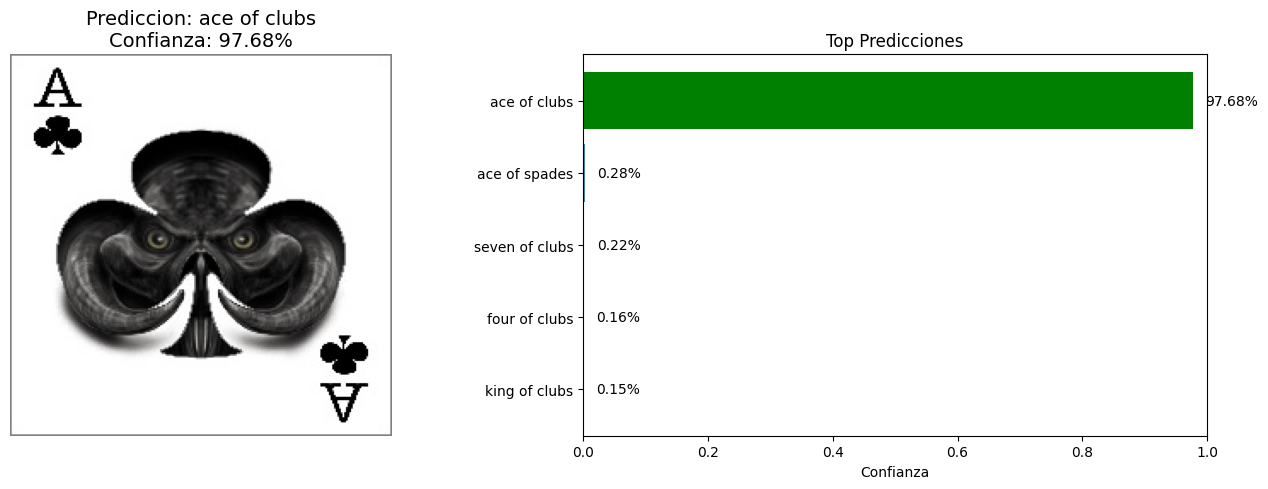


=== Resultado ===
Prediccion: ace of clubs
Confianza: 97.68%
Usando ensemble: True

Top 5 predicciones:
  1. ace of clubs: 97.68%
  2. ace of spades: 0.28%
  3. seven of clubs: 0.22%
  4. four of clubs: 0.16%
  5. king of clubs: 0.15%


In [7]:
# Probar con la primera imagen
if test_images:
    result = predict_card_from_path(str(test_images[0]), visualize=True, top_n=5)
    
    print('\n=== Resultado ===')
    print(f"Prediccion: {result['prediction']}")
    print(f"Confianza: {result['confidence']:.2%}")
    print(f"Usando ensemble: {result['is_ensemble']}")
    print('\nTop 5 predicciones:')
    for i, pred in enumerate(result['top_predictions'], 1):
        print(f"  {i}. {pred['class']}: {pred['confidence']:.2%}")

In [8]:
# Probar con multiples imagenes
print('\n=== Predicciones en lote ===\n')

for img_path in test_images:
    result = predict_card_from_path(str(img_path), visualize=False)
    true_class = img_path.parent.name
    correct = result['prediction'] == true_class
    status = '[OK]' if correct else '[X]'
    
    print(f"{status} True: {true_class:25} | Pred: {result['prediction']:25} | Conf: {result['confidence']:.2%}")


=== Predicciones en lote ===

[OK] True: ace of clubs              | Pred: ace of clubs              | Conf: 97.68%
[OK] True: ace of diamonds           | Pred: ace of diamonds           | Conf: 96.78%
[OK] True: ace of hearts             | Pred: ace of hearts             | Conf: 98.21%
[OK] True: ace of spades             | Pred: ace of spades             | Conf: 94.67%
[OK] True: eight of clubs            | Pred: eight of clubs            | Conf: 98.55%


## Funcion para prediccion en batch

In [9]:
def predict_batch(image_paths, visualize_errors=True, max_errors_shown=5):
    """
    Predecir multiples imagenes y reportar resultados.
    
    Args:
        image_paths: Lista de rutas a imagenes
        visualize_errors: Si True, visualiza predicciones incorrectas
        max_errors_shown: Maximo de errores a visualizar
    
    Returns:
        dict con estadisticas y resultados
    """
    results = []
    errors = []
    
    for img_path in image_paths:
        img_path = Path(img_path)
        true_class = img_path.parent.name
        
        result = predict_card_from_path(str(img_path), visualize=False)
        result['true_class'] = true_class
        result['correct'] = result['prediction'] == true_class
        
        results.append(result)
        
        if not result['correct']:
            errors.append(result)
    
    # Estadisticas
    accuracy = sum(r['correct'] for r in results) / len(results)
    avg_confidence = np.mean([r['confidence'] for r in results])
    avg_confidence_correct = np.mean([r['confidence'] for r in results if r['correct']])
    avg_confidence_wrong = np.mean([r['confidence'] for r in results if not r['correct']]) if errors else 0
    
    stats = {
        'total': len(results),
        'correct': sum(r['correct'] for r in results),
        'errors': len(errors),
        'accuracy': accuracy,
        'avg_confidence': avg_confidence,
        'avg_confidence_correct': avg_confidence_correct,
        'avg_confidence_wrong': avg_confidence_wrong
    }
    
    print('\n=== Estadisticas del Batch ===')
    print(f"Total imagenes: {stats['total']}")
    print(f"Correctas: {stats['correct']} ({stats['accuracy']:.2%})")
    print(f"Errores: {stats['errors']}")
    print(f"Confianza promedio: {stats['avg_confidence']:.2%}")
    print(f"Confianza en aciertos: {stats['avg_confidence_correct']:.2%}")
    if errors:
        print(f"Confianza en errores: {stats['avg_confidence_wrong']:.2%}")
    
    # Visualizar errores
    if visualize_errors and errors:
        print(f'\nMostrando {min(len(errors), max_errors_shown)} errores:')
        for error in errors[:max_errors_shown]:
            print(f"\nTrue: {error['true_class']} | Pred: {error['prediction']}")
            predict_card_from_path(error['image_path'], visualize=True)
    
    return {'stats': stats, 'results': results, 'errors': errors}

In [10]:
# Obtener mas imagenes para batch
all_test_images = []
for class_dir in test_path.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob('*.jpg'))  # todas por clase
        all_test_images.extend(images)

print(f'Total imagenes para batch: {len(all_test_images)}')

Total imagenes para batch: 265



=== Estadisticas del Batch ===
Total imagenes: 265
Correctas: 263 (99.25%)
Errores: 2
Confianza promedio: 92.91%
Confianza en aciertos: 93.25%
Confianza en errores: 48.27%

Mostrando 2 errores:

True: king of spades | Pred: queen of spades


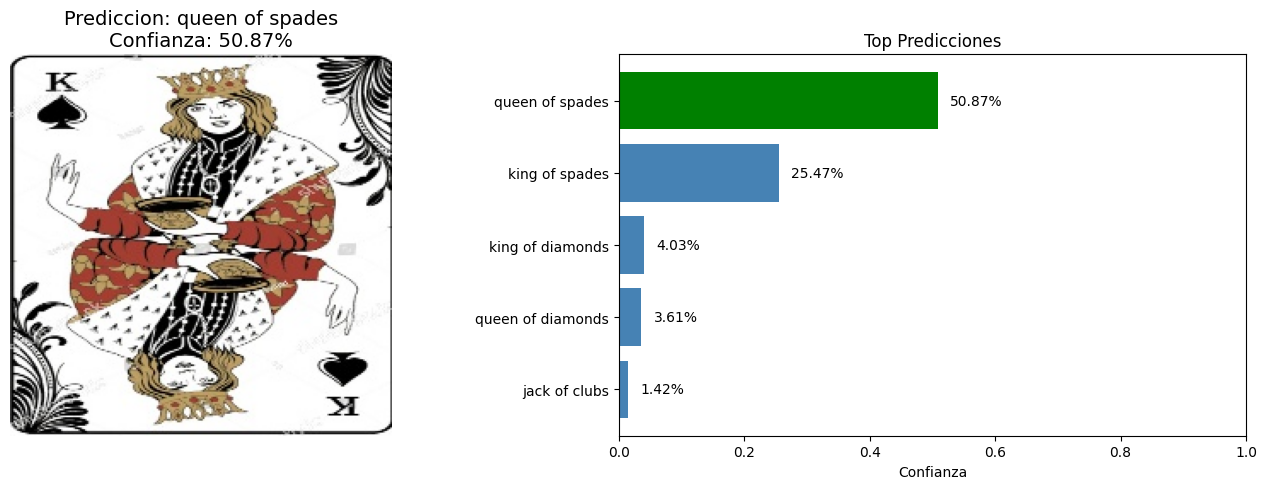


True: six of clubs | Pred: queen of clubs


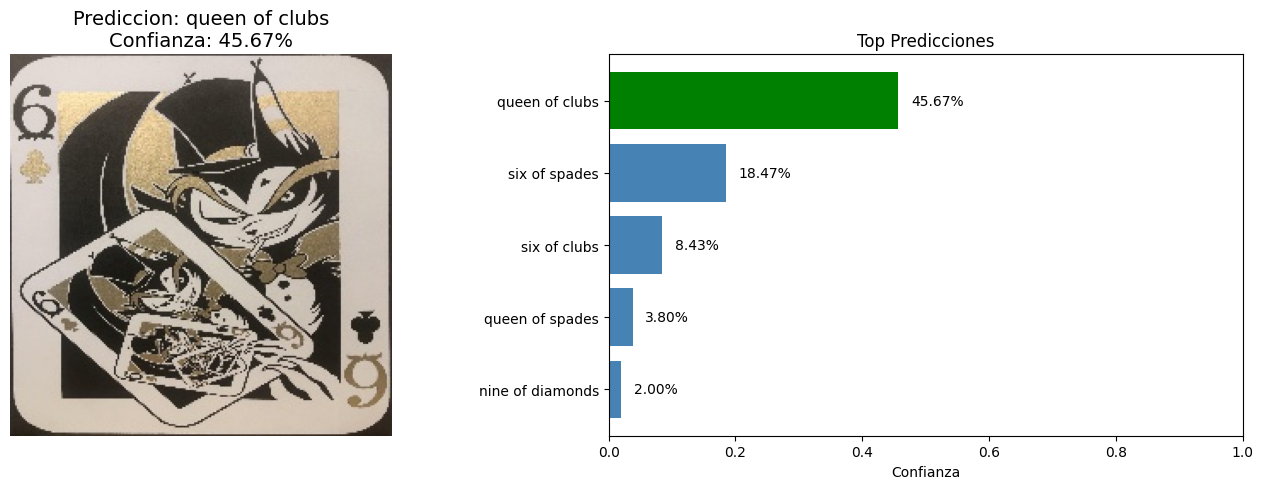

In [11]:
# Ejecutar prediccion en batch
batch_results = predict_batch(all_test_images, visualize_errors=True, max_errors_shown=7)

## Exportar funciones para uso externo

In [ ]:
# Guardar funciones en un modulo Python
inference_code = '''
"""Pipeline de inferencia para clasificacion de cartas."""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import json
from pathlib import Path

SIZE = 224

class CardClassifier:
    """Clasificador de cartas con soporte para modelo individual o ensemble."""
    
    def __init__(self, model_path=None, ensemble_config_path=None, class_names=None):
        self.class_names = class_names
        self.models = []
        self.weights = []
        self.is_ensemble = False
        
        if ensemble_config_path and os.path.exists(ensemble_config_path):
            self._load_ensemble(ensemble_config_path)
        elif model_path:
            self._load_single_model(model_path)
    
    def _load_single_model(self, model_path):
        self.models = [tf.keras.models.load_model(model_path)]
        self.weights = [1.0]
        self.is_ensemble = False
    
    def _load_ensemble(self, config_path):
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        model_dir = os.path.dirname(config_path)
        
        for model_file in config['model_files']:
            model_path = os.path.join(model_dir, model_file)
            if os.path.exists(model_path):
                self.models.append(tf.keras.models.load_model(model_path))
        
        weights_dict = config.get('weights', {})
        self.weights = list(weights_dict.values()) if weights_dict else [1.0] * len(self.models)
        total = sum(self.weights)
        self.weights = [w / total for w in self.weights]
        self.is_ensemble = len(self.models) > 1
    
    def preprocess_image(self, image_path):
        img = load_img(image_path, target_size=(SIZE, SIZE))
        img_array = img_to_array(img) / 255.0
        return np.expand_dims(img_array, axis=0)
    
    def predict(self, image_path, top_n=3):
        img_array = self.preprocess_image(image_path)
        
        if self.is_ensemble:
            predictions = self._ensemble_predict(img_array)
        else:
            predictions = self.models[0].predict(img_array, verbose=0)[0]
        
        top_indices = np.argsort(predictions)[-top_n:][::-1]
        
        return {
            'prediction': self.class_names[top_indices[0]],
            'confidence': float(predictions[top_indices[0]]),
            'top_predictions': [
                {'class': self.class_names[idx], 'confidence': float(predictions[idx])}
                for idx in top_indices
            ]
        }
    
    def _ensemble_predict(self, img_array):
        weighted_preds = np.zeros(len(self.class_names))
        for model, weight in zip(self.models, self.weights):
            preds = model.predict(img_array, verbose=0)[0]
            weighted_preds += preds * weight
        return weighted_preds


def predict_card_from_path(image_path, model_path=None, class_names=None, top_n=3):
    """
    Predecir la clase de una carta desde una imagen.
    
    Args:
        image_path: Ruta a la imagen
        model_path: Ruta al modelo .h5 (opcional)
        class_names: Lista de nombres de clases
        top_n: Numero de predicciones top
    
    Returns:
        dict con prediccion, confianza y top_predictions
    """
    classifier = CardClassifier(model_path=model_path, class_names=class_names)
    return classifier.predict(image_path, top_n=top_n)
'''

with open('card_inference.py', 'w') as f:
    f.write(inference_code)

print('Modulo card_inference.py guardado.')
print('\nUso:')
print('  from card_inference import predict_card_from_path')
print('  result = predict_card_from_path("path/to/image.jpg", model_path="Models/ViT_B16_2.h5", class_names=CLASS_NAMES)')

## Resumen

In [ ]:
print('='*60)
print('PIPELINE DE INFERENCIA - RESUMEN')
print('='*60)
print('''
Funciones disponibles:

1. predict_card_from_path(image_path, visualize=True, top_n=5)
   - Predice una carta desde una imagen
   - Muestra visualizacion con imagen y predicciones
   - Retorna dict con prediccion y confianza

2. predict_batch(image_paths, visualize_errors=True)
   - Predice multiples imagenes
   - Calcula estadisticas (accuracy, confianza)
   - Visualiza errores

3. CardClassifier(model_path=None, ensemble_config_path=None)
   - Clase completa para inferencia
   - Soporta modelo individual o ensemble
   - Metodos: predict(), visualize_prediction()

Ejemplo de uso:
    result = predict_card_from_path('path/to/card.jpg')
    print(result['prediction'])  # 'ace of spades'
    print(result['confidence'])  # 0.95
''')
print('='*60)